---

Libreta jupyter sobre el trabajo de investigación:

**"Estimación de la evapotranspiración espacio-temporal en arrozales usando imágenes satelitales, Departamento de Lambayeque"**

Autor: Cesar Francisco Vilca Gamarra 

Repositorio alojado en [GitHub](https://github.com/vilcagamarracf/Inv_arroz_METRIC) 

Marzo, 2022

---

# Visualizando imágenes

Libreta para seguir el conjunto de imagenes que vayan saliendo para el área de estudio.

## Inicio

In [1]:
# Ruta del directorio de trabajo
%pwd

'C:\\Users\\usuario\\Documents\\00-notebooks-2022'

In [1]:
# Earth Engine
import ee
ee.Initialize()

import geemap
import geemap.colormaps as cmp # Paletas para visualización de imágenes (cm se confunde con matplotlib)

import pandas as pd
from ipywidgets import interact, fixed
import os

import matplotlib.pyplot as plt

# Archivos .py con funciones
from vis_tools import *

In [ ]:
# import os
# os.chdir('C:\\Users\\usuario\\Documents\\00-notebooks-2022')
# os.getcwd()

In [30]:
# Por cada cambio se necesita usar importlib.reload
import importlib # Para volver a importar el archivo funciones.py posterior a cada cambio
import sys
# importlib.reload(sys.modules['vis_tools'])
importlib.reload(sys.modules['funciones'])

<module 'funciones' from 'C:\\Users\\usuario\\Documents\\00-notebooks-2022\\funciones.py'>

## Assets y ROI

In [2]:
# Diccionario de visualización de imágenes Landsat 8 y 9 TOA
vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 

In [3]:
# Assets
asset_dept = ee.FeatureCollection('users/CesarVilca/departamentos')
asset_prov = ee.FeatureCollection('users/CesarVilca/provincias')
asset_dist = ee.FeatureCollection('users/CesarVilca/distritos')

# Filtrado
deptSelectedName = 'LAMBAYEQUE'
provSelectedName = 'FERREÑAFE' # 'FERREÑAFE' 'CHICLAYO'
distSelectedName = 'FERREÑAFE' # 'FERREÑAFE' 'CHONGOYAPE'

dept_fcol = asset_dept.filterMetadata('DEPARTAMEN', 'equals', deptSelectedName)
prov_fcol = asset_prov.filterMetadata('PROVINCIA', 'equals', provSelectedName)
dist_fcol = asset_dist.filterMetadata('DISTRITO', 'equals', distSelectedName)

# ROI Caja
roi = dist_fcol.geometry().bounds()

empty = ee.Image().paint(dist_fcol, 2,2)
empty2 = ee.Image().paint(roi, 2, 2)

In [4]:
# Visualización
Map = geemap.Map(layer_ctrl = True) 
Map.centerObject(dist_fcol, 9)

Map.addLayer(dept_fcol, {'color':'red'}, f'Departamento {deptSelectedName}')
Map.addLayer(prov_fcol, {'color':'green'}, f'Provincia {provSelectedName} ')
Map.addLayer(dist_fcol, {'color':'blue'}, f'Distrito {distSelectedName}')

# Bordes
Map.addLayer(empty , {}, 'Distrito Seleccionado')
Map.addLayer(empty2, {}, 'Limites')

Map

Map(center=[-6.6205221157277006, -79.79111975903714], controls=(WidgetControl(options=['position', 'transparen…

In [4]:
# Archivos Vectoriales para filtrado y visualización

# ruta_ferrenafe = r'input/Ferreñafe_areas.shp' # en Local (Antiguo)
ruta_ferrenafe = r'input/Ferreñafe_areas_2.shp' # en Local (Modificado con imagen RGB de drone)
# ruta_ferrenafe = r'/content/Ferreñafe_areas.shp' # en Colab

predios_agricolas = geemap.shp_to_ee(ruta_ferrenafe)
predios_vis = ee.Image().byte().paint(predios_agricolas, 1, 1) # Para visualización con geemap

predios_bound = predios_agricolas.geometry().bounds()
predios_bound_vis = ee.Image().byte().paint(predios_bound, 1, 1) # Para visualización con geemap

# Area a visualizar 
roi_blend = ee.Image().paint(predios_agricolas, 0,5)

type(predios_agricolas)

ee.featurecollection.FeatureCollection

## Filtrado

In [6]:
# Filtrado
path = 10
row = 65 # 64

fecha = '2021-12'
meses = 7

### Landsat 8 y 9

#### T1_L2

In [7]:
tier = 'T1_L2'
icol_l8_id = f'LANDSAT/LC09/C02/{tier}'
icol_l9_id = f'LANDSAT/LC08/C02/{tier}'

# Generando L9 raw
icol_l9 = (
    ee.ImageCollection(icol_l9_id)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL9_raw = generar_reporte(icol_l9).sort_values('Fecha Corta')

# Generando L8 raw

icol_l8 = (
    ee.ImageCollection(icol_l8_id)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL8_raw = generar_reporte(icol_l8).sort_values('Fecha Corta')

# Concatenar DataFrames
df_l8_l9 = pd.concat([reporteL9_raw, reporteL8_raw])

# Ordenar fechas
df_l8_l9 = df_l8_l9.sort_values('Fecha Corta') # De mayor a menor usar: ,ascending=False

df_l8_l9 = df_l8_l9.reset_index(drop=True)
df_l8_l9

ID GEE           Fecha Precisa  \
0   LANDSAT/LC08/C02/T1_L2/LC08_010065_20211204 2021-12-04 10:28:39.679   
1   LANDSAT/LC09/C02/T1_L2/LC09_010065_20211212 2021-12-12 10:28:36.901   
2   LANDSAT/LC08/C02/T1_L2/LC08_010065_20211220 2021-12-20 10:28:37.250   
3   LANDSAT/LC09/C02/T1_L2/LC09_010065_20211228 2021-12-28 10:28:35.288   
4   LANDSAT/LC08/C02/T1_L2/LC08_010065_20220105 2022-01-05 10:28:32.585   
5   LANDSAT/LC09/C02/T1_L2/LC09_010065_20220113 2022-01-13 10:28:31.598   
6   LANDSAT/LC08/C02/T1_L2/LC08_010065_20220121 2022-01-21 10:28:28.991   
7   LANDSAT/LC09/C02/T1_L2/LC09_010065_20220129 2022-01-29 10:28:34.404   
8   LANDSAT/LC08/C02/T1_L2/LC08_010065_20220206 2022-02-06 10:28:25.404   
9   LANDSAT/LC09/C02/T1_L2/LC09_010065_20220214 2022-02-14 10:28:30.097   
10  LANDSAT/LC08/C02/T1_L2/LC08_010065_20220222 2022-02-22 10:28:19.582   
11  LANDSAT/LC09/C02/T1_L2/LC09_010065_20220302 2022-03-02 10:28:18.905   
12  LANDSAT/LC08/C02/T1_L2/LC08_010065_20220310 2022-03-10 10:28:16.344   
13  LANDSAT/LC08/C02/T1_L2/LC08_010065_20220326 2022-03-26 10:28:05.040   
14  LANDSAT/LC09/C02/T1_L2/LC09_010065_20220403 2022-04-03 10:28:14.419   
15  LANDSAT/LC08/C02/T1_L2/LC08_010065_20220411 2022-04-11 10:28:07.262   
16  LANDSAT/LC09/C02/T1_L2/LC09_010065_20220419 2022-04-19 10:28:04.864   
17  LANDSAT/LC08/C02/T1_L2/LC08_010065_20220427 2022-04-27 10:28:03.632   
18  LANDSAT/LC09/C02/T1_L2/LC09_010065_20220505 2022-05-05 10:28:00.205   
19  LANDSAT/LC08/C02/T1_L2/LC08_010065_20220513 2022-05-13 10:28:13.037   
20  LANDSAT/LC09/C02/T1_L2/LC09_010065_20220521 2022-05-21 10:27:48.502   
21  LANDSAT/LC08/C02/T1_L2/LC08_010065_20220529 2022-05-29 10:28:15.046   
22  LANDSAT/LC09/C02/T1_L2/LC09_010065_20220606 2022-06-06 10:27:50.027   
23  LANDSAT/LC08/C02/T1_L2/LC08_010065_20220614 2022-06-14 10:28:27.904   
24  LANDSAT/LC09/C02/T1_L2/LC09_010065_20220622 2022-06-22 10:28:07.026   
25  LANDSAT/LC08/C02/T1_L2/LC08_010065_20220630 2022-06-30 10:28:32.507   

   Fecha Corta   Año  Mes  Día  Día Juliano  CLOUD_COVER  ZENITH ANGLE  \
0   2021-12-04  2021   12    4          338        41.76     28.768697   
1   2021-12-12  2021   12   12          346        46.62           NaN   
2   2021-12-20  2021   12   20          354        67.62     30.803453   
3   2021-12-28  2021   12   28          362        83.81           NaN   
4   2022-01-05  2022    1    5            5        42.07     32.035861   
5   2022-01-13  2022    1   13           13        32.92           NaN   
6   2022-01-21  2022    1   21           21        37.22     32.321836   
7   2022-01-29  2022    1   29           29        21.24           NaN   
8   2022-02-06  2022    2    6           37        52.05     31.847376   
9   2022-02-14  2022    2   14           45        88.04           NaN   
10  2022-02-22  2022    2   22           53        38.32     31.047292   
11  2022-03-02  2022    3    2           61        79.22           NaN   
12  2022-03-10  2022    3   10           69        29.20     30.539493   
13  2022-03-26  2022    3   26           85        93.24     30.864288   
14  2022-04-03  2022    4    3           93         4.82           NaN   
15  2022-04-11  2022    4   11          101        76.52     32.271818   
16  2022-04-19  2022    4   19          109        39.87           NaN   
17  2022-04-27  2022    4   27          117        63.67     34.498473   
18  2022-05-05  2022    5    5          125        42.44           NaN   
19  2022-05-13  2022    5   13          133        69.41     37.080163   
20  2022-05-21  2022    5   21          141        24.13           NaN   
21  2022-05-29  2022    5   29          149        13.55     39.421653   
22  2022-06-06  2022    6    6          157        79.90           NaN   
23  2022-06-14  2022    6   14          165        13.43     41.001884   
24  2022-06-22  2022    6   22          173         2.76           NaN   
25  2022-06-30  2022    6   30          181        26.98     41.449848   

    SUN_ELEVATIO

#### T1

In [8]:
tier = 'T1'
icol_l8_id = f'LANDSAT/LC09/C02/{tier}'
icol_l9_id = f'LANDSAT/LC08/C02/{tier}'

# Generando L9 raw
icol_l9 = (
    ee.ImageCollection(icol_l9_id)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL9_raw = generar_reporte(icol_l9).sort_values('Fecha Corta')

# Generando L8 raw

icol_l8 = (
    ee.ImageCollection(icol_l8_id)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL8_raw = generar_reporte(icol_l8).sort_values('Fecha Corta')

# Concatenar DataFrames
df_l8_l9 = pd.concat([reporteL9_raw, reporteL8_raw])

# Ordenar fechas
df_l8_l9 = df_l8_l9.sort_values('Fecha Corta') # De mayor a menor usar: ,ascending=False

df_l8_l9 = df_l8_l9.reset_index(drop=True)
df_l8_l9

ID GEE           Fecha Precisa  \
0   LANDSAT/LC08/C02/T1/LC08_010065_20211204 2021-12-04 10:28:39.679   
1   LANDSAT/LC09/C02/T1/LC09_010065_20211212 2021-12-12 10:28:36.901   
2   LANDSAT/LC08/C02/T1/LC08_010065_20211220 2021-12-20 10:28:37.250   
3   LANDSAT/LC09/C02/T1/LC09_010065_20211228 2021-12-28 10:28:35.288   
4   LANDSAT/LC08/C02/T1/LC08_010065_20220105 2022-01-05 10:28:32.585   
5   LANDSAT/LC09/C02/T1/LC09_010065_20220113 2022-01-13 10:28:31.598   
6   LANDSAT/LC08/C02/T1/LC08_010065_20220121 2022-01-21 10:28:28.991   
7   LANDSAT/LC09/C02/T1/LC09_010065_20220129 2022-01-29 10:28:34.404   
8   LANDSAT/LC08/C02/T1/LC08_010065_20220206 2022-02-06 10:28:25.404   
9   LANDSAT/LC09/C02/T1/LC09_010065_20220214 2022-02-14 10:28:30.097   
10  LANDSAT/LC08/C02/T1/LC08_010065_20220222 2022-02-22 10:28:19.582   
11  LANDSAT/LC09/C02/T1/LC09_010065_20220302 2022-03-02 10:28:18.905   
12  LANDSAT/LC08/C02/T1/LC08_010065_20220310 2022-03-10 10:28:16.344   
13  LANDSAT/LC09/C02/T1/LO09_010065_20220318 2022-03-18 10:28:18.136   
14  LANDSAT/LC08/C02/T1/LC08_010065_20220326 2022-03-26 10:28:05.040   
15  LANDSAT/LC09/C02/T1/LC09_010065_20220403 2022-04-03 10:28:14.419   
16  LANDSAT/LC08/C02/T1/LC08_010065_20220411 2022-04-11 10:28:07.262   
17  LANDSAT/LC09/C02/T1/LC09_010065_20220419 2022-04-19 10:28:04.864   
18  LANDSAT/LC08/C02/T1/LC08_010065_20220427 2022-04-27 10:28:03.632   
19  LANDSAT/LC09/C02/T1/LC09_010065_20220505 2022-05-05 10:28:00.205   
20  LANDSAT/LC08/C02/T1/LC08_010065_20220513 2022-05-13 10:28:13.037   
21  LANDSAT/LC09/C02/T1/LC09_010065_20220521 2022-05-21 10:27:48.502   
22  LANDSAT/LC08/C02/T1/LC08_010065_20220529 2022-05-29 10:28:15.046   
23  LANDSAT/LC09/C02/T1/LC09_010065_20220606 2022-06-06 10:27:50.027   
24  LANDSAT/LC08/C02/T1/LC08_010065_20220614 2022-06-14 10:28:27.904   
25  LANDSAT/LC09/C02/T1/LC09_010065_20220622 2022-06-22 10:28:07.026   
26  LANDSAT/LC08/C02/T1/LC08_010065_20220630 2022-06-30 10:28:32.507   

   Fecha Corta   Año  Mes  Día  Día Juliano  CLOUD_COVER  SUN_ELEVATION  
0   2021-12-04  2021   12    4          338        41.76      61.231303  
1   2021-12-12  2021   12   12          346        46.62      60.112699  
2   2021-12-20  2021   12   20          354        67.62      59.196546  
3   2021-12-28  2021   12   28          362        83.81      58.451368  
4   2022-01-05  2022    1    5            5        42.07      57.964139  
5   2022-01-13  2022    1   13           13        32.92      57.699649  
6   2022-01-21  2022    1   21           21        37.22      57.678164  
7   2022-01-29  2022    1   29           29        21.24      57.844082  
8   2022-02-06  2022    2    6           37        52.05      58.152624  
9   2022-02-14  2022    2   14           45        88.04      58.557062  
10  2022-02-22  2022    2   22           53        38.32      58.952708  
11  2022-03-02  2022    3    2           61        79.22      59.298992  
12  2022-03-10  2022    3   10           69        29.20      59.460507  
13  2022-03-18  2022    3   18           77        24.89      59.452908  
14  2022-03-26  2022    3   26           85        93.24      59.135712  
15  2022-04-03  2022    4    3           93         4.82      58.593556  
16  2022-04-11  2022    4   11          101        76.52      57.728182  
17  2022-04-19  2022    4   19          109        39.87      56.709960  
18  2022-04-27  2022    4   27          117        63.67      55.501527  
19  2022-05-05  2022    5    5          125        42.44      54.184383  
20  2022-05-13  2022    5   13          133        69.41      52.919837  
21  2022-05-21  2022    5   21          141        24.13      51.608921  
22  2022-05-29  2022    5   29          149        13.55      50.578347  
23  2022-06-06  2022    6    6          157        79.90      49.577674  
24  2022-06-14  2022    6   14          165        13.43      48.998116  
25  2022-06-22  2022    6   22          173         2.76      48.538488  
26  2022-06-30  2022   

#### TOA

In [17]:
tier = 'T1_TOA'

icol_l8_id = f'LANDSAT/LC09/C02/{tier}'
icol_l9_id = f'LANDSAT/LC08/C02/{tier}'

# Generando L9 raw
icol_l9 = (
    ee.ImageCollection(icol_l9_id)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL9_raw = generar_reporte(icol_l9).sort_values('Fecha Corta')

# Generando L8 raw

icol_l8 = (
    ee.ImageCollection(icol_l8_id)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL8_raw = generar_reporte(icol_l8).sort_values('Fecha Corta')

# Concatenar DataFrames
df_l8_l9 = pd.concat([reporteL9_raw, reporteL8_raw])

# Ordenar fechas
df_l8_l9 = df_l8_l9.sort_values('Fecha Corta') # De mayor a menor usar: ,ascending=False

df_l8_l9 = df_l8_l9.reset_index(drop=True)
df_l8_l9

ID GEE           Fecha Precisa  \
0   LANDSAT/LC08/C02/T1_TOA/LC08_010065_20211204 2021-12-04 10:28:39.679   
1   LANDSAT/LC09/C02/T1_TOA/LC09_010065_20211212 2021-12-12 10:28:36.901   
2   LANDSAT/LC08/C02/T1_TOA/LC08_010065_20211220 2021-12-20 10:28:37.250   
3   LANDSAT/LC09/C02/T1_TOA/LC09_010065_20211228 2021-12-28 10:28:35.288   
4   LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220105 2022-01-05 10:28:32.585   
5   LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220113 2022-01-13 10:28:31.598   
6   LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220121 2022-01-21 10:28:28.991   
7   LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220129 2022-01-29 10:28:34.404   
8   LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220206 2022-02-06 10:28:25.404   
9   LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220214 2022-02-14 10:28:30.097   
10  LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220222 2022-02-22 10:28:19.582   
11  LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220302 2022-03-02 10:28:18.905   
12  LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220310 2022-03-10 10:28:16.344   
13  LANDSAT/LC09/C02/T1_TOA/LO09_010065_20220318 2022-03-18 10:28:18.136   
14  LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220326 2022-03-26 10:28:05.040   
15  LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220403 2022-04-03 10:28:14.419   
16  LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220411 2022-04-11 10:28:07.262   
17  LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220419 2022-04-19 10:28:04.864   
18  LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220427 2022-04-27 10:28:03.632   
19  LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220505 2022-05-05 10:28:00.205   
20  LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220513 2022-05-13 10:28:13.037   
21  LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220521 2022-05-21 10:27:48.502   
22  LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220529 2022-05-29 10:28:15.046   
23  LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220606 2022-06-06 10:27:50.027   
24  LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220614 2022-06-14 10:28:27.904   
25  LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220622 2022-06-22 10:28:07.026   
26  LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220630 2022-06-30 10:28:32.507   

   Fecha Corta   Año  Mes  Día  Día Juliano  CLOUD_COVER  SUN_ELEVATION  
0   2021-12-04  2021   12    4          338        41.76      61.231303  
1   2021-12-12  2021   12   12          346        46.62      60.112699  
2   2021-12-20  2021   12   20          354        67.62      59.196546  
3   2021-12-28  2021   12   28          362        83.81      58.451368  
4   2022-01-05  2022    1    5            5        42.07      57.964139  
5   2022-01-13  2022    1   13           13        32.92      57.699649  
6   2022-01-21  2022    1   21           21        37.22      57.678164  
7   2022-01-29  2022    1   29           29        21.24      57.844082  
8   2022-02-06  2022    2    6           37        52.05      58.152624  
9   2022-02-14  2022    2   14           45        88.04      58.557062  
10  2022-02-22  2022    2   22           53        38.32      58.952708  
11  2022-03-02  2022    3    2           61        79.22      59.298992  
12  2022-03-10  2022    3   10           69        29.20      59.460507  
13  2022-03-18  2022    3   18           77        24.89      59.452908  
14  2022-03-26  2022    3   26           85        93.24      59.135712  
15  2022-04-03  2022    4    3           93         4.82      58.593556  
16  2022-04-11  2022    4   11          101        76.52      57.728182  
17  2022-04-19  2022    4   19          109        39.87      56.709960  
18  2022-04-27  2022    4   27          117        63.67      55.501527  
19  2022-05-05  2022    5    5          125        42.44      54.184383  
20  2022-05-13  2022    5   13          133        69.41      52.919837  
21  2022-05-21  2022    5   21          141        24.13      51.608921  
22  2022-05-29  2022    5   29          149        13.55      50.578347  
23  2022-06-06  2022    6    6          157        79.90      49.577674  
24  2022-06-14  2022    6   14          165        13.43      4

In [8]:
# Guardar dataframe
# df_l8_l9.to_csv('reporte-L8_L9.csv', index=False, encoding='utf-8-sig')

In [9]:
df_reporte = df_l8_l9
  
# Visualizar imágenes por mes
mes = df_reporte['Mes'].unique().tolist()
interact(ver_imgs_mensual, 
         mes=mes, 
         snippet_name =fixed(snippet_name), 
         df=fixed(df_reporte), 
         roi=fixed(predios_agricolas));

interactive(children=(Dropdown(description='mes', options=(12, 1, 2, 3, 4, 5, 6), value=12), Output()), _dom_c…

### Sentinel-2

In [18]:
# Filtrado Sentinel-2
snippet_name_s2 = 'COPERNICUS/S2'
# snippet_name_s2 = 'COPERNICUS/S2_SR'

icol_s2_sr = (
    ee.ImageCollection(snippet_name_s2)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterBounds(predios_agricolas)
)

reporteS2 = generar_reporte(icol_s2_sr)
reporteS2

ID GEE           Fecha Precisa  \
0   COPERNICUS/S2/20211202T153621_20211202T154056_... 2021-12-02 10:45:07.038   
1   COPERNICUS/S2/20211207T153619_20211207T153726_... 2021-12-07 10:45:02.453   
2   COPERNICUS/S2/20211212T153621_20211212T154103_... 2021-12-12 10:45:06.775   
3   COPERNICUS/S2/20211217T153609_20211217T153742_... 2021-12-17 10:45:01.362   
4   COPERNICUS/S2/20211222T153621_20211222T154116_... 2021-12-22 10:45:08.640   
5   COPERNICUS/S2/20211227T153619_20211227T153744_... 2021-12-27 10:45:03.076   
6   COPERNICUS/S2/20220101T153621_20220101T154106_... 2022-01-01 10:45:09.178   
7   COPERNICUS/S2/20220106T153619_20220106T153727_... 2022-01-06 10:45:03.572   
8   COPERNICUS/S2/20220111T153621_20220111T154058_... 2022-01-11 10:45:08.654   
9   COPERNICUS/S2/20220116T153619_20220116T153730_... 2022-01-16 10:45:03.128   
10  COPERNICUS/S2/20220121T153621_20220121T153934_... 2022-01-21 10:45:07.445   
11  COPERNICUS/S2/20220126T153619_20220126T153649_... 2022-01-26 10:45:01.518   
12  COPERNICUS/S2/20220131T153621_20220131T153814_... 2022-01-31 10:45:07.558   
13  COPERNICUS/S2/20220205T153619_20220205T153613_... 2022-02-05 10:45:01.885   
14  COPERNICUS/S2/20220210T153621_20220210T154143_... 2022-02-10 10:45:06.405   
15  COPERNICUS/S2/20220215T153609_20220215T153612_... 2022-02-15 10:45:01.233   
16  COPERNICUS/S2/20220220T153621_20220220T153621_... 2022-02-20 10:45:09.286   
17  COPERNICUS/S2/20220225T153619_20220225T153614_... 2022-02-25 10:45:03.207   
18  COPERNICUS/S2/20220302T153621_20220302T153622_... 2022-03-02 10:45:11.024   
19  COPERNICUS/S2/20220307T153619_20220307T153616_... 2022-03-07 10:45:05.086   
20  COPERNICUS/S2/20220312T153621_20220312T153627_... 2022-03-12 10:45:11.545   
21  COPERNICUS/S2/20220317T153619_20220317T154033_... 2022-03-17 10:45:05.551   
22  COPERNICUS/S2/20220322T153621_20220322T153622_... 2022-03-22 10:45:10.593   
23  COPERNICUS/S2/20220327T153619_20220327T154047_... 2022-03-27 10:45:04.649   
24  COPERNICUS/S2/20220401T153621_20220401T154251_... 2022-04-01 10:45:09.554   
25  COPERNICUS/S2/20220406T153619_20220406T154150_... 2022-04-06 10:45:04.341   
26  COPERNICUS/S2/20220411T153621_20220411T154026_... 2022-04-11 10:45:09.571   
27  COPERNICUS/S2/20220416T153619_20220416T153615_... 2022-04-16 10:45:02.318   
28  COPERNICUS/S2/20220421T153621_20220421T153959_... 2022-04-21 10:45:12.042   
29  COPERNICUS/S2/20220426T153609_20220426T154437_... 2022-04-26 10:45:00.909   
30  COPERNICUS/S2/20220501T153621_20220501T154228_... 2022-05-01 10:45:12.570   
31  COPERNICUS/S2/20220506T153619_20220506T153615_... 2022-05-06 10:45:03.505   
32  COPERNICUS/S2/20220511T153621_20220511T154121_... 2022-05-11 10:45:11.052   
33  COPERNICUS/S2/20220516T153619_20220516T154342_... 2022-05-16 10:45:06.732   
34  COPERNICUS/S2/20220521T153631_20220521T153954_... 2022-05-21 10:45:14.017   
35  COPERNICUS/S2/20220526T153619_20220526T154401_... 2022-05-26 10:45:07.657   
36  COPERNICUS/S2/20220531T153631_20220531T153627_... 2022-05-31 10:45:15.308   
37  COPERNICUS/S2/20220605T153619_20220605T154426_... 2022-06-05 10:45:08.245   
38  COPERNICUS/S2/20220610T153631_20220610T154138_... 2022-06-10 10:45:16.817   
39  COPERNICUS/S2/20220615T153619_20220615T154006_... 2022-06-15 10:45:11.097   
40  COPERNICUS/S2/20220620T153631_20220620T153631_... 2022-06-20 10:45:19.352   
41  COPERNICUS/S2/20220625T153629_20220625T154022_... 2022-06-25 10:45:12.401   

   Fecha Corta   Año  Mes  Día  Día Juliano  MEAN SOLAR ZENITH ANGLE  \
0   2021-12-02  2021   12    2          336                25.107220   
1   2021-12-07  2021   12    7          341                25.872739   
2   2021-12-12  2021   12   12          346                26.540952   
3   2021-12-17  2021   12   17          351                27.156068   
4   2021-12-22  2021   12   22          356                27.636708   
5   2021-12-27  2021   12   27          361                28.058020   
6   2022-01-01  2022    1    1            1                

In [ ]:
# Exportar .csv
reporteS2.to_csv('reporte-S2.csv', index=False, encoding='utf-8-sig')

**Visualización**

A partir del mes de Febrero se puede observar que las imágenes se encuentran afectadas por un tono de color blanco. A la hora de exportar las imágenes más adelante se ve la posible mejora de visualización modificando el parámetro gamma.

In [11]:
# Ver imágenes por mes

df_reporte = reporteS2

mes = df_reporte['Mes'].unique().tolist()

interact(ver_imgs_mensual, 
         mes=mes, 
         snippet_name =fixed(snippet_name_s2), 
         df=fixed(df_reporte), 
         roi=fixed(predios_agricolas));

interactive(children=(Dropdown(description='mes', options=(12, 1, 2, 3, 4, 5, 6), value=12), Output()), _dom_c…

### Histórico de imágenes Landsat y Sentinel-2

Requiere:
- Haber realizado el filtrado para ambos datasets Landsat y Sentinel

**Gráficas interactivas con plotly**

Referencias:
- [Python Figure Reference: layout](https://plotly.com/python/reference/layout/)

In [12]:
import plotly.graph_objects as go

In [13]:
# Visualización con Plotly

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=reporteL8_raw['Fecha Precisa'], 
               y=reporteL8_raw['CLOUD_COVER'],
               name=icol_l8_id, 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers',
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{y}%',
               line = dict(width=2)
               )
    )

fig.add_trace(
    go.Scatter(x=reporteS2['Fecha Precisa'], 
               y=reporteS2['CLOUDY PIXEL PERCENTAGE'],
               name='Sentinel-2', 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers',
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{y:.2f}%',
               line = dict(width=2, dash='dot')
               )
    )

fig.add_trace(
    go.Scatter(x=reporteL9_raw['Fecha Precisa'], 
               y=reporteL9_raw['CLOUD_COVER'], 
               name=icol_l9_id, 
               marker_color= 'blue',
               mode='lines+markers', marker_size=7,
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{y}%',
               line = dict(width=2)
              #  line = dict(width=2, dash='dot')
               )
    )

# fig.update_traces(mode = 'markers', marker_size=7)

# Título y hover
title_plotly = f'Imágenes Landsat 8, 9 y Sentinel-2'

fig.update_layout(
    plot_bgcolor = "white",
#     width = 800, 
    height = 400,
    hovermode="x unified",
    title = title_plotly,
    yaxis_range = [0,100],
#     xaxis_range = [fecha, pd.to_datetime(fecha) + relativedelta(months=meses)],
#  https://stackoverflow.com/questions/4130922/how-to-increment-datetime-by-custom-months-in-python-without-using-library
    margin=dict(t=75, b=25, l=0, r=0),
    legend=dict(x=0.27, y=-0.10),      # Posición de leyenda
    legend_orientation='h',
    font_family='sans-serif'
)

# Nombres en ejes
fig.update_yaxes(
    title_text='Nubosidad (%)',
    showline=False, linecolor='black', mirror=True,
    gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, 
    linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )

fig.show()

**Exportar gráfica como archivo `.html`**

- [Plotly: Interactive HTML Export in Python](https://plotly.com/python/interactive-html-export/)

In [ ]:
# Exportar grafica como archivo html
fig.write_html('Historico L8, L9 y S2.html')

### Exportar histórico de imágenes con `cartoee` 

#### Función `get_grafica_cartoee_color`

In [21]:
import cartopy.crs as ccrs

def get_grafica_cartoee_color(image, 
                              vis_params,                              
                              text=None, 
                              title_map=None,
                              label=None, 
                              save_fig=None,
                              nogrid=None):
    
    """Obtener gráficas con cartoee
    La variable zoom_region debe asignarse según la zona de estudio.
    Para modificaciones seguir: https://geemap.org/cartoee/#cartoee-module

    Las gráficas se guardaran en la carpeta base "C:/Users/usuario/Documents/00-notebooks-2022/"
    """

    # Establecer área de plot usando las coordenadas de predios_bound.coordinates().getInfo()
    extent = 0.0005
    zoom_region = [
        -79.77332525015065+extent, -6.605665317455976-extent,
        -79.78719338866794-extent, -6.594549+extent
    ]
    
    # Establecer figsize para plot
    # fig = plt.figure(figsize=(5,5)) # Para juntar en forma de mosaicos
    fig = plt.figure(figsize=(8,6)) # Para analizar
    # fig = plt.figure(figsize=(16,12)) # Para recortar la barra
    
    # ee.Image a plotear
    ax = cartoee.get_map(image, region=zoom_region, vis_params=vis_params)

    # Añadir grillas
    if nogrid is None:
        cartoee.add_gridlines(ax, 
                              interval=0.005, 
                              ytick_rotation=90, 
                              linestyle=":", 
                              linewidth=0 # Grillas invisibles
                              ) # xtick_rotation=45
    
    # Añadir barra de color
    if label is not None:
        cartoee.add_colorbar(ax, 
                             vis_params=vis_params, 
                             loc='right', 
                             # label=label, 
                             #posOpts=[0.86, 0.25, 0.02, 0.5],
                             tick_font_size=12
                             # ticks=[15, 20, 25, 30, 35], # LAI
                             # drawedges=True, 
                             # extend='both', # Genera flechas hacia los extremos
                             )
        ax.text(-79.77332525015065+2*extent, -6.5956, label, fontsize=12)

    # Añadir texto
    if title_map is not None:
        ax.set_title(title_map) # , fontsize=11
        
    if text is not None:
        ax.text(-79.7872, -6.6056, text, fontsize=12) 
        # fontsize=18 para mejor visibilidad en mosaicos
        
    # add scale bar
    scale_bar_dict = {
          "length": 100, 
          "xy": (0.9, 0.05), 
          "linewidth": 2,
          "fontsize": 12,
          "color": "black",
          "unit": "m",
          "ha": "center",
          "va": "bottom",    
    }
    cartoee.add_scale_bar_lite(ax, **scale_bar_dict)
    
    ax.tick_params(axis = 'both') # , labelsize = 9
    
    # Guardar graficas
    if save_fig is not None:
        ruta = r'C:/Users/usuario/Documents/00-notebooks-2022/'
        ruta_img = os.path.join(ruta, save_fig + '.jpg')
        plt.savefig(ruta_img, bbox_inches = 'tight', pad_inches = .1)#, dpi=400)
        # Recortar márgenes con ayuda de bbox_inches y pad_inches

    plt.show()

####  Imágenes Landsat 8 y 9

In [13]:
# -----------------------------------------------
# Estableciendo parámetros de plots en Matplotlib
# -----------------------------------------------

plt.rcParams['font.family'] = 'serif' #  'Arial', default es'sans-serif'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.dpi'] = 72

# Manejo de warning: https://stackoverflow.com/questions/27476642/matplotlib-get-rid-of-max-open-warning-output
plt.rcParams.update({'figure.max_open_warning': 0})

##### Gráfica 4x3 Landsat

In [ ]:
# Elaborar listas para leerse en los bucles for
def cortar_lista(lista, x):
    lista_nueva = df_l8_l9['ID GEE'].tolist()[x:x+3]
    return lista_nueva

lista = df_l8_l9['ID GEE'].tolist()

# Ejemplo
lista_imgs = [cortar_lista(lista, 0),
              cortar_lista(lista, 3),
              cortar_lista(lista, 6),
              cortar_lista(lista, 9),
              cortar_lista(lista, 12)]
lista_imgs

Visualización de histórico de imágenes satelitales con `cartoee`

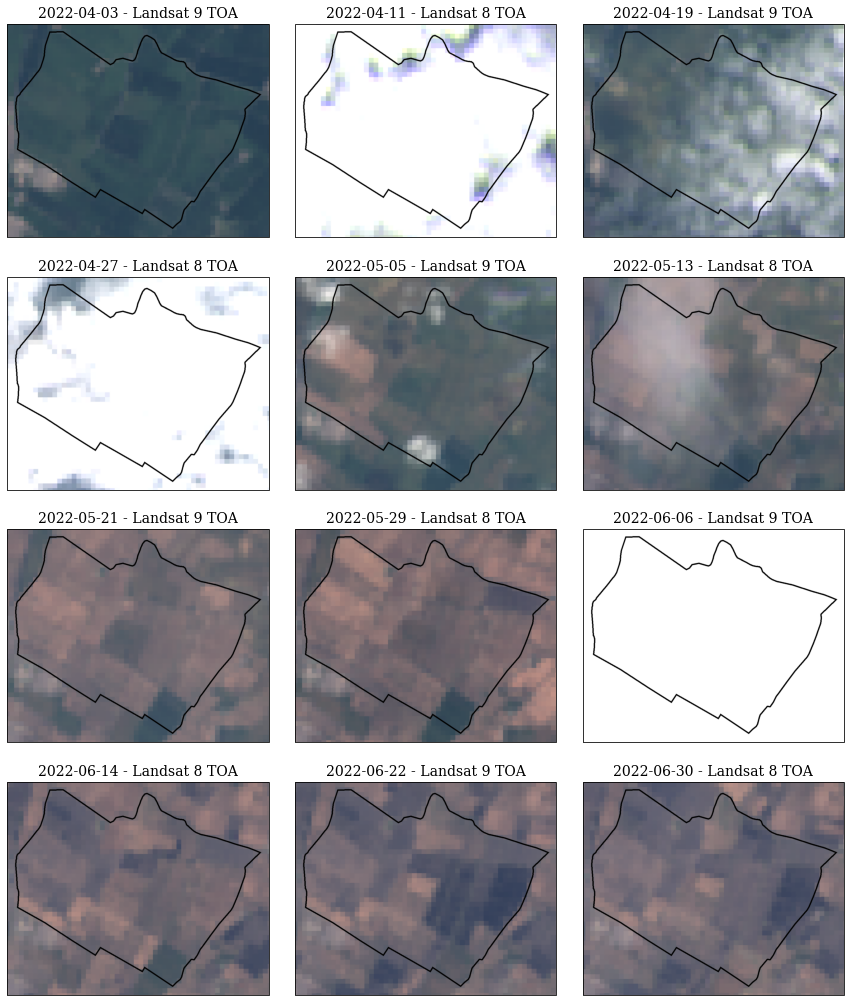

In [79]:
# -----------------------------
# Parámetros de imágenes
# -----------------------------

lista = df_l8_l9['ID GEE'].tolist()

# Primer mosaico
# lista_imgs = [cortar_lista(lista, 0),
#               cortar_lista(lista, 3),
#               cortar_lista(lista, 6),
#               cortar_lista(lista, 9),
#               cortar_lista(lista, 12)]

# ids_lista = df_l8_l9['ID GEE'].tolist()[:15]

# Segundo mosaico
lista_imgs = [cortar_lista(lista, 15),
              cortar_lista(lista, 18),
              cortar_lista(lista, 21),
              cortar_lista(lista, 24)]

nrows = len(lista_imgs)
ncols = 3

ids_lista = df_l8_l9['ID GEE'].tolist()[15:]

extent = 0.0005
zoom_region = [
    -79.77332525015065+extent, -6.605665317455976-extent,
    -79.78719338866794-extent, -6.594549+extent
]
dims = 1000

# -----------------------------
# Parámetros de gráfica
# -----------------------------

fig = plt.figure(figsize=(5*ncols, 4.5*nrows)) # , linewidth=10, edgecolor="#04253a"
gs = fig.add_gridspec(ncols=ncols, nrows=nrows, wspace=0.1, hspace=0.05)
axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

for row in range(nrows):
    lista_a_usar = lista_imgs[row]
    
    for col in range(ncols):
        img_id = lista_a_usar[col]
        landsat_id = img_id[11:12]
        img_ee = ee.Image(img_id)
        img_ee_vis = img_ee.blend(roi_blend) # .clip(predios_agricolas)
        img_date = img_ee.date().format('YYYY-MM-dd').getInfo()
        
        cartoee.add_layer(axs[row, col], img_ee_vis, dims=dims, region=zoom_region, vis_params=vis_rgb)
        axs[row, col].set_title(f'{img_date} - Landsat {landsat_id} TOA')
        

In [80]:
fig.savefig('imagen_prueba2.jpg', bbox_inches='tight', pad_inches=.1) #, dpi=400)

In [27]:
# Prueba: Evaluando tipos de ejes en gráficas
print(type(gs))
print(type(axs))

<class 'matplotlib.gridspec.GridSpec'>
<class 'numpy.ndarray'>


#### Imágenes Landsat 8 y 9

In [ ]:
# Imagenes a plotear
ids_lista = df_l8_l9['ID GEE'].tolist()
# ids_lista = df_l8_l9[df_l8_l9['Mes']==6]['ID GEE'].tolist() # Filtrar por Mes X

path = 'output/imagenes/rgb landsat'

for img_id in ids_lista:

    # Imagen por id
    landsat_id = img_id[11:12]
    img_ee = ee.Image(img_id)
    img_ee_vis = img_ee.blend(roi_blend) # .clip(predios_agricolas)
    
    # Extraer datos de img
    img_date = img_ee.date().format('YYYY-MM-dd').getInfo()
    title_map = f'{img_date} - Landsat {landsat_id} TOA'
    save_fig = f'{path}/{img_date}_L{landsat_id}'

    # Gráfica con cartoee
    get_grafica_cartoee_color(img_ee_vis, 
                              vis_rgb, 
                              title_map=title_map,
                              nogrid=True,
                              save_fig=save_fig)

#### Imágenes Sentinel-2

In [ ]:
# Obtener gráficas para cada imagen
vis_params_sent = {'min': 0, 'max': 0.3, 'bands': ['B4','B3','B2'], 'gamma':0.6}

lista_ids = reporteS2['ID GEE'].tolist()
# lista_ids = reporteS2[reporteS2['Mes']==1]['ID GEE'].tolist()

path = 'output/imagenes/rgb sentinel'

for img_id in lista_ids:
    
    img_sent = ee.Image(img_id)
    img_sent_vis = img_sent.multiply(0.0001).blend(roi_blend) # .clip(predios_agricolas)

    img_date = img_sent.date().format('YYYY-MM-dd').getInfo()
    title_map = f'{img_date} - Sentinel-2 TOA'
    save_fig = f'{path}/{img_date}_S2'
    
    get_grafica_cartoee_color(img_sent_vis, 
                              vis_params_sent, 
                              title_map=title_map,
                              nogrid=True,
                              save_fig=save_fig)

#### Pruebas

In [ ]:
# # Prueba: Recortar las imágenes de una carpeta en específico
# # Nota: Usar solo para recortar imágenes que lo necesiten y no olvidar borrar el archivo phototumb.db
# path = r'C:\Users\usuario\Documents\00-notebooks-2022\images\cartoee\RGB\Prueba_PLOTEO\recortados'
# list_imgs = os.listdir(path)
# # list_imgs

# import matplotlib.image as mpimg

# plt.figure(1)
# for i in range(len(list_imgs)):
#     img_path = path+"\\"+list_imgs[i]
#     img = mpimg.imread(img_path)[25:335,:] # Con grilla
#     # img = mpimg.imread(img_path)[0:330,:] # Sin grilla
#     plt.imsave(img_path, img) # https://www.delftstack.com/howto/numpy/save-numpy-array-as-image/